In [1]:
from elasticsearch import Elasticsearch
import pandas as pd

es = Elasticsearch("http://localhost:9200", basic_auth=("elastic", "NiTcEgNphln17-PjmS_f"))

response = es.search(
    index="app-logs",
    size=1000,
     body={
        "query": {
            "exists": {
            "field" : "geoip"
            }
        }
           },
)

data = [doc['_source'] for doc in response['hits']['hits']]
df = pd.DataFrame(data)
print(df.head(10))

C:\Users\Ojas Gandheel\AppData\Local\Temp\ipykernel_5432\1930121871.py:6: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(


                ip                @timestamp  \
0     144.8.75.189  2025-06-17T10:15:18.000Z   
1    24.85.243.248  2025-06-17T12:28:08.000Z   
2    19.56.241.190  2025-06-17T11:47:45.000Z   
3      149.82.22.8  2025-06-17T06:11:04.000Z   
4    82.161.58.192  2025-06-17T13:08:33.000Z   
5  144.164.194.204  2025-06-17T11:31:16.000Z   
6    141.22.41.210  2025-06-17T13:11:56.000Z   
7     132.7.239.51  2025-06-17T06:37:05.000Z   
8    163.64.80.149  2025-06-17T07:33:34.000Z   
9   136.85.152.234  2025-06-17T13:47:29.000Z   

                                                 log  \
0  {'file': {'path': 'E:/Downloads/application_lo...   
1  {'file': {'path': 'E:/Downloads/application_lo...   
2  {'file': {'path': 'E:/Downloads/application_lo...   
3  {'file': {'path': 'E:/Downloads/application_lo...   
4  {'file': {'path': 'E:/Downloads/application_lo...   
5  {'file': {'path': 'E:/Downloads/application_lo...   
6  {'file': {'path': 'E:/Downloads/application_lo...   
7  {'file': {'path': 'E

In [8]:
numeric_cols=df_clean.select_dtypes(include=['int64' , 'float64']).columns
categorical_cols = df_clean.select_dtypes(include=['object','category','bool']).columns                              
print(numeric_cols)
print(categorical_cols)

Index([], dtype='object')
Index(['ip', 'log', 'geoip', '@version', 'user_id', 'host', 'level',
       'timestamp', 'event', 'service', 'message'],
      dtype='object')


In [3]:
del df['@timestamp']


In [4]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [5]:
print(df['timestamp'])

0     2025-06-17 15:45:18
1     2025-06-17 17:58:08
2     2025-06-17 17:17:45
3     2025-06-17 11:41:04
4     2025-06-17 18:38:33
              ...        
995   2025-06-17 14:35:56
996   2025-06-17 14:46:42
997   2025-06-17 19:53:07
998   2025-06-17 17:23:31
999   2025-06-17 15:40:39
Name: timestamp, Length: 1000, dtype: datetime64[ns]


In [6]:
def sanitize_column(col, keep='all'):
    def extract(x):
        if isinstance(x, dict):
            return str(x) if keep == 'all' else str(next(iter(x.values()), ''))
        elif isinstance(x, list):
            return str(x) if keep == 'all' else str(x[0]) if x else ''
        elif pd.isna(x):
            return ''
        else:
            return str(x)
    return col.apply(extract)


In [7]:
df_clean = df.apply(sanitize_column)

In [9]:
print(df_clean)

                  ip                                                log  \
0       144.8.75.189  {'file': {'path': 'E:/Downloads/application_lo...   
1      24.85.243.248  {'file': {'path': 'E:/Downloads/application_lo...   
2      19.56.241.190  {'file': {'path': 'E:/Downloads/application_lo...   
3        149.82.22.8  {'file': {'path': 'E:/Downloads/application_lo...   
4      82.161.58.192  {'file': {'path': 'E:/Downloads/application_lo...   
..               ...                                                ...   
995    83.178.97.127  {'file': {'path': 'E:/Downloads/application_lo...   
996   106.89.207.248  {'file': {'path': 'E:/Downloads/application_lo...   
997   205.200.84.128  {'file': {'path': 'E:/Downloads/application_lo...   
998    47.138.171.79  {'file': {'path': 'E:/Downloads/application_lo...   
999  114.241.111.181  {'file': {'path': 'E:/Downloads/application_lo...   

                                                 geoip @version user_id  \
0    {'timezone': 'Ameri

In [10]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df_clean[categorical_cols])

In [11]:
print(encoded_cats)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
encoded_cats.shape

(1000, 5962)

In [15]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.1 , random_state = 42)
model.fit(encoded_cats)

df_clean['anomaly_score'] = model.decision_function(encoded_cats)
df_clean['anomaly'] = model.predict(encoded_cats)

In [16]:
anomalies = df_clean[df_clean['anomaly'] == -1]
anomalies.to_csv("xyz2.csv", index=False)

In [17]:
features_names = encoder.get_feature_names_out()
print(features_names)

['ip_1.142.131.220' 'ip_1.176.108.241' 'ip_100.254.65.50' ...
 "message_['[2025-06-17 19:59:36] INFO | notification-service | Failed to send notification | user_id=u26150 | ip=90.99.187.46', 'Failed to send notification']"
 "message_['[2025-06-17 19:59:37] INFO | payment-service | Payment failed | user_id=u11731 | ip=106.54.45.188 | amount=277.52 USD | txn_id=662ec402-5a4f-46f2-aac7-d210e4e47fdf', 'Payment failed']"
 "message_['[2025-06-17 19:59:49] DEBUG | user-service | New user registered | user_id=u78784 | ip=206.157.169.220', 'New user registered']"]


In [18]:
import pandas as pd
user_ip_group = df.groupby('user_id')['ip'].unique().reset_index()
user_ip_group['ip_count'] = user_ip_group['ip'].apply(len)
suspicious_users_df = user_ip_group[user_ip_group['ip_count'] > 1]
print(suspicious_users_df)


    user_id                                ip  ip_count
120  u22430     [149.7.70.160, 161.37.115.99]         2
126  u22899     [164.50.37.94, 155.22.88.133]         2
210  u31515    [157.90.219.3, 112.50.245.148]         2
259  u35728    [27.119.186.62, 24.249.94.239]         2
441  u53193  [116.209.37.231, 188.106.163.30]         2


In [19]:
suspicious_users_df.to_csv("sususers.csv" , index=False)

In [20]:
anomaly_indices = df_clean[df_clean['anomaly'] == -1].index
subset_encoded = encoded_cats[anomaly_indices]
from sklearn.cluster import MiniBatchKMeans
actual_batch_size = min(2048, len(subset_encoded))
kmeans = MiniBatchKMeans(n_clusters=3, n_init=3 ,  batch_size = actual_batch_size , random_state=42)
cluster_labels = kmeans.fit_predict(subset_encoded)
df_clean.loc[anomaly_indices, 'anomaly_type'] = cluster_labels


C:\Users\Ojas Gandheel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [21]:
print(df_clean[df_clean['anomaly'] == -1])
    

                 ip                                                log  \
0      144.8.75.189  {'file': {'path': 'E:/Downloads/application_lo...   
24    70.117.126.92  {'file': {'path': 'E:/Downloads/application_lo...   
39   64.250.110.128  {'file': {'path': 'E:/Downloads/application_lo...   
40   58.189.230.180  {'file': {'path': 'E:/Downloads/application_lo...   
48    48.134.168.87  {'file': {'path': 'E:/Downloads/application_lo...   
..              ...                                                ...   
946    166.39.89.70  {'file': {'path': 'E:/Downloads/application_lo...   
973   94.175.39.194  {'file': {'path': 'E:/Downloads/application_lo...   
984  74.189.101.104  {'file': {'path': 'E:/Downloads/application_lo...   
986    69.128.99.49  {'file': {'path': 'E:/Downloads/application_lo...   
988    51.7.214.119  {'file': {'path': 'E:/Downloads/application_lo...   

                                                 geoip @version user_id  \
0    {'timezone': 'America/Chicago',

In [20]:
anomalies_zero = df_clean[df_clean['anomaly_type']==0]
print(anomalies_zero)
anomalies_zero.to_csv("anomalies_zero" , index=False)

                  ip                                                log  \
24     70.117.126.92  {'file': {'path': 'E:/Downloads/application_lo...   
39    64.250.110.128  {'file': {'path': 'E:/Downloads/application_lo...   
48     48.134.168.87  {'file': {'path': 'E:/Downloads/application_lo...   
75    137.250.90.120  {'file': {'path': 'E:/Downloads/application_lo...   
101      67.93.8.149  {'file': {'path': 'E:/Downloads/application_lo...   
112  163.225.225.101  {'file': {'path': 'E:/Downloads/application_lo...   
126     164.50.37.94  {'file': {'path': 'E:/Downloads/application_lo...   
160  106.228.166.231  {'file': {'path': 'E:/Downloads/application_lo...   
210    99.236.44.185  {'file': {'path': 'E:/Downloads/application_lo...   
215     62.75.179.93  {'file': {'path': 'E:/Downloads/application_lo...   
252   215.220.83.205  {'file': {'path': 'E:/Downloads/application_lo...   
253    216.215.77.10  {'file': {'path': 'E:/Downloads/application_lo...   
264     84.76.27.151  {'f

In [21]:
anomalies_first = df_clean[df_clean['anomaly_type']==1]
print(anomalies_first)
anomalies_first.to_csv("anomalies_first" , index=False)

                  ip                                                log  \
0       144.8.75.189  {'file': {'path': 'E:/Downloads/application_lo...   
52     41.31.211.101  {'file': {'path': 'E:/Downloads/application_lo...   
63   185.173.154.240  {'file': {'path': 'E:/Downloads/application_lo...   
65     15.100.171.81  {'file': {'path': 'E:/Downloads/application_lo...   
93    101.104.218.86  {'file': {'path': 'E:/Downloads/application_lo...   
197  125.207.217.131  {'file': {'path': 'E:/Downloads/application_lo...   
227      117.58.8.26  {'file': {'path': 'E:/Downloads/application_lo...   
235   77.219.136.169  {'file': {'path': 'E:/Downloads/application_lo...   
302  155.160.233.236  {'file': {'path': 'E:/Downloads/application_lo...   
361    211.220.46.71  {'file': {'path': 'E:/Downloads/application_lo...   
407    133.53.54.181  {'file': {'path': 'E:/Downloads/application_lo...   
421    40.123.140.11  {'file': {'path': 'E:/Downloads/application_lo...   
443     173.24.47.54  {'f

In [22]:
anomalies_second = df_clean[df_clean['anomaly_type']==2]
print(anomalies_second)
anomalies_second.to_csv("anomalies_second" , index=False)

                  ip                                                log  \
40    58.189.230.180  {'file': {'path': 'E:/Downloads/application_lo...   
209   67.217.172.203  {'file': {'path': 'E:/Downloads/application_lo...   
214   135.226.80.109  {'file': {'path': 'E:/Downloads/application_lo...   
219    41.24.176.157  {'file': {'path': 'E:/Downloads/application_lo...   
241  116.141.139.158  {'file': {'path': 'E:/Downloads/application_lo...   
271     2.201.26.223  {'file': {'path': 'E:/Downloads/application_lo...   
355   195.33.230.101  {'file': {'path': 'E:/Downloads/application_lo...   
367  218.144.249.195  {'file': {'path': 'E:/Downloads/application_lo...   
394  139.169.130.230  {'file': {'path': 'E:/Downloads/application_lo...   
401    95.57.198.210  {'file': {'path': 'E:/Downloads/application_lo...   
428   57.213.137.147  {'file': {'path': 'E:/Downloads/application_lo...   
483  150.252.155.178  {'file': {'path': 'E:/Downloads/application_lo...   
508   171.45.114.144  {'f

In [23]:
ip_indices = [i for i, name in enumerate(encoder.get_feature_names_out()) if name.startswith('ip')]
ip_subset = encoded_cats[:, ip_indices]
iso = IsolationForest(contamination=0.1, random_state=42)
df_clean['ip_anomaly_score'] = iso.fit(ip_subset).decision_function(ip_subset)
df_clean['ip_anomaly'] = iso.predict(ip_subset)


In [24]:
print(df_clean[df_clean['ip_anomaly']==-1])

                  ip                                                log  \
37    110.126.152.54  {'file': {'path': 'E:/Downloads/application_lo...   
49    205.200.84.128  {'file': {'path': 'E:/Downloads/application_lo...   
61      2.226.70.187  {'file': {'path': 'E:/Downloads/application_lo...   
64    75.139.127.247  {'file': {'path': 'E:/Downloads/application_lo...   
67    42.247.237.201  {'file': {'path': 'E:/Downloads/application_lo...   
..               ...                                                ...   
947   159.169.37.189  {'file': {'path': 'E:/Downloads/application_lo...   
969  200.158.212.123  {'file': {'path': 'E:/Downloads/application_lo...   
978  108.103.166.189  {'file': {'path': 'E:/Downloads/application_lo...   
997   205.200.84.128  {'file': {'path': 'E:/Downloads/application_lo...   
998    47.138.171.79  {'file': {'path': 'E:/Downloads/application_lo...   

                                                 geoip @version user_id  \
37   {'timezone': 'Asia/

In [25]:
cols_to_exclude = ['anomaly_score', 'anomaly' , 'anomaly_type']
df_clean_filtered = df_clean.drop(columns=cols_to_exclude)  
ipanomalies = df_clean_filtered[df_clean_filtered['ip_anomaly']==-1]
ipanomalies.to_csv("ip.csv", index=False)

In [26]:
df_sorted = df_clean.sort_values(by='ip_anomaly_score')
print(df_sorted[['ip', 'ip_anomaly_score']].head(10))


                 ip  ip_anomaly_score
103  122.192.99.207         -0.006806
64   75.139.127.247         -0.006188
685  130.41.181.109         -0.005982
259  162.55.215.185         -0.005776
728   55.10.109.182         -0.005776
446  121.170.87.141         -0.005776
248    6.22.128.221         -0.005160
650  201.69.143.120         -0.005160
131   15.227.128.26         -0.004303
657  198.83.221.138         -0.004136


C:\Users\Ojas Gandheel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


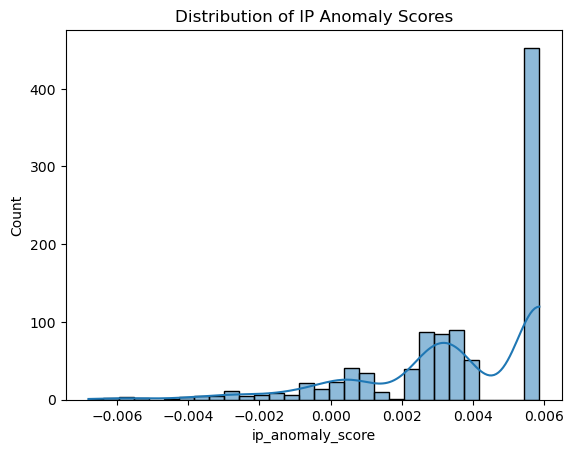

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_clean['ip_anomaly_score'], bins=30, kde=True)
plt.title('Distribution of IP Anomaly Scores')
plt.show()


In [28]:
ip_subset.shape

(1000, 993)

In [29]:
import pandas as pd

data = [
    {
        "ip": "46.141.93.16",
        "ip_anomaly_score": -0.00348341231722132,
        "service": "auth-service",
        "user_id": "u98434",
        "message": "[Invalid login attempt]"
    },
    {
        "ip": "174.1.232.252",
        "ip_anomaly_score": -0.000807366374713958,
        "service": "auth-service",
        "user_id": "u72394",
        "message": "[Invalid login attempt]"
    }
]

dff = pd.DataFrame(data)
dff.to_csv("rare_ips_with_invalid_login_attempt.csv", index=False)
print(dff)


              ip  ip_anomaly_score       service user_id  \
0   46.141.93.16         -0.003483  auth-service  u98434   
1  174.1.232.252         -0.000807  auth-service  u72394   

                   message  
0  [Invalid login attempt]  
1  [Invalid login attempt]  


In [30]:
import ipaddress

def ip_to_int(ip_str):
    return int(ipaddress.IPv4Address(ip_str))

df_clean['ip_int'] = df_clean['ip'].apply(ip_to_int)
print(df_clean['ip_int'].head())

0    2416462781
1     408286200
2     322499006
3    2505184776
4    1386298048
Name: ip_int, dtype: int64


In [31]:
print(df_clean)

                  ip                                                log  \
0       144.8.75.189  {'file': {'path': 'E:/Downloads/application_lo...   
1      24.85.243.248  {'file': {'path': 'E:/Downloads/application_lo...   
2      19.56.241.190  {'file': {'path': 'E:/Downloads/application_lo...   
3        149.82.22.8  {'file': {'path': 'E:/Downloads/application_lo...   
4      82.161.58.192  {'file': {'path': 'E:/Downloads/application_lo...   
..               ...                                                ...   
995    83.178.97.127  {'file': {'path': 'E:/Downloads/application_lo...   
996   106.89.207.248  {'file': {'path': 'E:/Downloads/application_lo...   
997   205.200.84.128  {'file': {'path': 'E:/Downloads/application_lo...   
998    47.138.171.79  {'file': {'path': 'E:/Downloads/application_lo...   
999  114.241.111.181  {'file': {'path': 'E:/Downloads/application_lo...   

                                                 geoip @version user_id  \
0    {'timezone': 'Ameri

In [32]:
X = df_clean[['ip_int']]
mod = IsolationForest(contamination=0.05, random_state=42)
mod.fit(X)
df_clean['ac_score'] = mod.decision_function(X)
df_clean['ac'] = mod.predict(X)

C:\Users\Ojas Gandheel\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [33]:
range = df_clean[df_clean['ac']==-1]
range.to_csv("ip_range.csv" , index=False)

In [34]:
print(df_clean.sort_values(by='ac_score'))

                 ip                                                log  \
654   1.142.131.220  {'file': {'path': 'E:/Downloads/application_lo...   
553   1.176.108.241  {'file': {'path': 'E:/Downloads/application_lo...   
729     2.0.119.175  {'file': {'path': 'E:/Downloads/application_lo...   
884   223.211.159.9  {'file': {'path': 'E:/Downloads/application_lo...   
74   223.218.93.133  {'file': {'path': 'E:/Downloads/application_lo...   
..              ...                                                ...   
757  64.128.161.135  {'file': {'path': 'E:/Downloads/application_lo...   
347   64.98.105.118  {'file': {'path': 'E:/Downloads/application_lo...   
967   64.73.214.152  {'file': {'path': 'E:/Downloads/application_lo...   
634     64.61.72.61  {'file': {'path': 'E:/Downloads/application_lo...   
898    64.38.160.86  {'file': {'path': 'E:/Downloads/application_lo...   

                                                 geoip @version user_id  \
654  {'timezone': 'Australia/Sydney'

In [45]:
!pip install geoip2 maxminddb-geolite2 scikit-learn pandas
import geoip2.database
reader = geoip2.database.Reader('E:/Downloads/GeoLite2-City_20250610/GeoLite2-City_20250610/GeoLite2-City.mmdb')
print(reader)

In [46]:
print(reader)

In [47]:
def get_geo_features(ip):
   try:
     res=reader.city(ip)
     return{
       'country': res.country.iso_code,
       'latitude': res.location.latitude,
       'longitude': res.location.longitude
        }
   except:
     return{'country':None , 'latitude':None , 'longitude':None}  

In [48]:
geo_features=df_clean['ip'].apply(lambda ip: get_geo_features(ip))
df_geo = pd.json_normalize(geo_features)
df_clean = pd.concat([df_clean , df_geo] , axis=1)

In [49]:
print(df_clean)

                  ip                                                log  \
0       144.8.75.189  {'file': {'path': 'E:/Downloads/application_lo...   
1      24.85.243.248  {'file': {'path': 'E:/Downloads/application_lo...   
2      19.56.241.190  {'file': {'path': 'E:/Downloads/application_lo...   
3        149.82.22.8  {'file': {'path': 'E:/Downloads/application_lo...   
4      82.161.58.192  {'file': {'path': 'E:/Downloads/application_lo...   
..               ...                                                ...   
995    83.178.97.127  {'file': {'path': 'E:/Downloads/application_lo...   
996   106.89.207.248  {'file': {'path': 'E:/Downloads/application_lo...   
997   205.200.84.128  {'file': {'path': 'E:/Downloads/application_lo...   
998    47.138.171.79  {'file': {'path': 'E:/Downloads/application_lo...   
999  114.241.111.181  {'file': {'path': 'E:/Downloads/application_lo...   

                                                 geoip @version user_id  \
0    {'timezone': 'Ameri

In [50]:
feat = df_clean[['latitude','longitude']].dropna()
print(feat)

     latitude  longitude
0     37.7510   -97.8220
1     49.2624  -123.1604
2     37.7510   -97.8220
3     37.7510   -97.8220
4     52.2106     4.5561
..        ...        ...
995   56.9473    24.0979
996   34.7732   113.7220
997   49.8179   -97.1535
998   33.8137  -117.2228
999   39.9110   116.3950

[1000 rows x 2 columns]


In [51]:
from sklearn.ensemble import IsolationForest
op = IsolationForest(n_estimators = 100 , contamination = 0.1 , random_state=42)
op.fit(feat)
df_clean['op_score']=op.decision_function(feat)
df_clean['is_anomaly']=op.predict(feat)
print(df_clean['is_anomaly'])

C:\Users\Ojas Gandheel\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


0      1
1     -1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: is_anomaly, Length: 1000, dtype: int32


In [52]:
geoanomaly = df_clean[df_clean['is_anomaly']==-1]
geoanomaly.to_csv("geoanomaly.csv" , index=False)

In [53]:
print(df_clean['op_score'].max())
print(df_clean['op_score'].min())

0.23820467221511354
-0.1217832635645586
